# Question 2b6_a_ii_1
For RNN networks implemented in (3) and (4), perform the following experiments with the aim of improving performances, compare the accuracies and report your findings:

a. Replace the GRU layer with (i) a vanilla RNN layer and (ii) a LSTM layer

b. Increase the number of RNN layers to 2 layers

c. Add gradient clipping to RNN training with clipping threshold = 2.

# Imports and Setup

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# chuanxin
%cd "../gdrive/My Drive/cz4042_assignment_2/2b" 

Mounted at /gdrive
/gdrive/My Drive/cz4042_assignment_2/2b


In [2]:
import os
import time
import json
import csv
import re

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf

In [3]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# Helper functions

### read_data_chars()
Used to load in the data. Returns x_train, y_train, x_test, y_test

In [4]:
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

### vocabulary(strings)
Read data with [character]. Get the unique characters in this strings and the vocab size (of characters)

In [5]:
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

### preprocess(strings, char_to_ix, MAX_LENGTH)
Clean up a string 

In [6]:
def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

### make_directories()
Used to create directories that might not have been made

In [7]:
# Create folder to store histories and figures
def make_directories():
  if not os.path.exists('./histories'):
    os.mkdir('./histories')
  if not os.path.exists('./figures'):
    os.mkdir('./figures')

### history_saver(history, filename, already_json=False)
Used to save a history object

In [8]:
# filename like 'history/model_name.json'
def history_saver(history, model_name, already_json=False):
  history_json = {}

  if already_json:
    history_json = history
  else:
    history = history.history
    for key in history.keys():
      history_json[key] = history[key]

  with open('./histories/' + model_name, 'w') as file:
    json.dump(history_json, file)

  print("History saved")

### history_loader(filename)
Used to load in a json history object

In [9]:
# filename like 'history/model_name.json'
def history_loader(model_name):
  with open('./histories/'+model_name) as json_file:
    history = json.load(json_file)
  print('History loaded')
  
  return history 

### plot_loss(history_json, model_name)
Plot out loss graph, and also save it

In [10]:
def plot_loss(history_json, model_name):
  train_loss = history_json['loss']
  test_loss = history_json['test_loss']
  title = 'Model name: ' + model_name + '\nloss against epochs'

  plt.plot(train_loss, label='train')
  plt.plot(test_loss, label='test')
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_loss.png')
  
  plt.show()

### plot_acc(history_json, model_name)
Plot out accuracy graph, and also save it

In [11]:
def plot_acc(history_json, model_name):
  train_acc = history_json['accuracy']
  test_acc = history_json['test_accuracy']
  title = 'Model name: ' + model_name + '\naccuracy against epochs'

  plt.plot(train_acc, label='train')
  plt.plot(test_acc, label='test')
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_accuracy.png')
  
  plt.show()

# 2b6_a_ii_1 - CharRNN (LSTM)

In [12]:
tf.keras.backend.set_floatx('float32')
class CharRNN(tf.keras.Model):
  def __init__(self, vocab_size, use_dropout, hidden_dims, rnn_type, num_rnn_layers):
    super(CharRNN, self).__init__()
    self.vocab_size = vocab_size
    self.use_dropout = use_dropout

    # Weight variables and RNN cell
    self.hidden_dims = hidden_dims
    self.rnn_type = rnn_type
    self.num_rnn_layers = num_rnn_layers

    if self.rnn_type == 'GRU' and self.num_rnn_layers == 1:
      self.rnn1 = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.hidden_dims), unroll=True)
    elif self.rnn_type == 'GRU' and self.num_rnn_layers == 2:
      self.rnn1 = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.hidden_dims), unroll=True, return_sequences=True)
      self.rnn2 = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.hidden_dims), unroll=True)
    elif self.rnn_type == 'SimpleRNN' and self.num_rnn_layers == 1:
      self.rnn1 = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(self.hidden_dims), unroll=True)     
    elif self.rnn_type == 'SimpleRNN' and self.num_rnn_layers == 2:
      self.rnn1 = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(self.hidden_dims), unroll=True, return_sequences=True)
      self.rnn2 = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(self.hidden_dims), unroll=True)     
    elif self.rnn_type == 'LSTM' and self.num_rnn_layers == 1:
      self.rnn1 = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(self.hidden_dims), unroll=True)
    elif self.rnn_type == 'LSTM' and self.num_rnn_layers == 2:
      self.rnn1 = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(self.hidden_dims), unroll=True, return_sequences=True)
      self.rnn2 = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(self.hidden_dims), unroll=True)
    else:
      print("wrong input")   

    self.dense = tf.keras.layers.Dense(MAX_LABEL, activation=None)

  def call(self, x, drop_rate):
    # forward
    x = tf.one_hot(x, one_hot_size)
    encoding = self.rnn1(x)
    if self.num_rnn_layers == 2:
      encoding = self.rnn2(encoding)
    if self.use_dropout:
      encoding = tf.nn.dropout(encoding, drop_rate)
    logits = self.dense(encoding)
    return logits

In [13]:
# Training function
def train_step(model, x, label, optimizer, drop_rate):
  with tf.GradientTape() as tape:
    out = model(x, drop_rate)
    loss = loss_object(label, out)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      
  train_loss(loss)
  train_accuracy(label, out)

# Testing function
def test_step(model, x, label, drop_rate):
  out = model(x,drop_rate)
  t_loss = loss_object(label, out)
  test_loss(t_loss)
  test_accuracy(label, out)

In [14]:
def fit(model):
  train_acc_list, train_loss_list, test_acc_list, test_loss_list = [], [], [], []
  time_start = time.perf_counter()

  for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_accuracy.reset_states()
    train_loss.reset_states()
    test_accuracy.reset_states()
    test_loss.reset_states()

    for images, labels in train_ds:
      train_step(model, images, labels, optimizer, 0.5)

    for images, labels in test_ds:
      test_step(model, images, labels, 0)

    
    train_acc_list.append(train_accuracy.result())
    train_loss_list.append(train_loss.result())
    test_acc_list.append(test_accuracy.result())
    test_loss_list.append(test_loss.result())

    template = 'Epoch {}, train_accuracy: {}, train_loss: {}, test_accuracy: {}, test_loss: {}'
    print (template.format(epoch+1,
                          train_accuracy.result(),
                          train_loss.result(),
                          test_accuracy.result(),
                          test_loss.result()))

  time_stop = time.perf_counter()
  time_taken = time_stop-time_start

  return train_acc_list, train_loss_list, test_acc_list, test_loss_list, time_taken

### Parameters

In [15]:
MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
RNN_TYPE = 'LSTM'
NUM_RNN_LAYERS = 1
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 100
lr = 0.01

In [16]:
# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [17]:
# Training and test
make_directories()
x_train, y_train, x_test, y_test = read_data_chars()

# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [18]:
model = CharRNN(256, False, HIDDEN_SIZE, RNN_TYPE, NUM_RNN_LAYERS)
model_name = 'q6_a_ii_1_char_rnn_lstm'
train_acc_list, train_loss_list, test_acc_list, test_loss_list, time_taken = fit(model)

Epoch 1, train_accuracy: 0.0880357176065445, train_loss: 2.6399502754211426, test_accuracy: 0.10285714268684387, test_loss: 2.6033241748809814
Epoch 2, train_accuracy: 0.11589285731315613, train_loss: 2.59340763092041, test_accuracy: 0.13571429252624512, test_loss: 2.546356439590454
Epoch 3, train_accuracy: 0.12321428209543228, train_loss: 2.5702905654907227, test_accuracy: 0.11999999731779099, test_loss: 2.6043102741241455
Epoch 4, train_accuracy: 0.1301785707473755, train_loss: 2.571991205215454, test_accuracy: 0.1128571406006813, test_loss: 2.613832712173462
Epoch 5, train_accuracy: 0.1294642835855484, train_loss: 2.5728659629821777, test_accuracy: 0.11999999731779099, test_loss: 2.57287859916687
Epoch 6, train_accuracy: 0.15232142806053162, train_loss: 2.5060155391693115, test_accuracy: 0.15285713970661163, test_loss: 2.5760326385498047
Epoch 7, train_accuracy: 0.14446428418159485, train_loss: 2.5329208374023438, test_accuracy: 0.1428571492433548, test_loss: 2.5149285793304443
Epoc

In [19]:
for metric_list in [train_acc_list, train_loss_list, test_acc_list, test_loss_list]:
  metric_list[:] = [x.numpy() for x in metric_list]
  metric_list[:] = [x.astype(float) for x in metric_list]

In [20]:
history_json = {model_name: {
    'accuracy': train_acc_list,
    'test_accuracy': test_acc_list,
    'loss': train_loss_list,
    'test_loss': test_loss_list,
    'time_taken': time_taken
}}

history_saver(history_json, model_name, already_json=True)
histories_json = history_loader(model_name)

History saved
History loaded


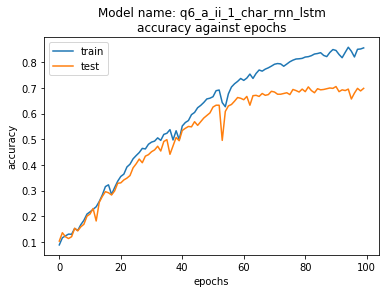

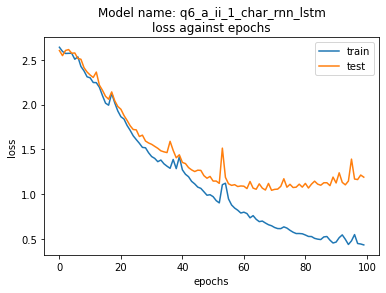

In [21]:
plot_acc(histories_json[model_name], model_name)
plot_loss(histories_json[model_name], model_name)

In [22]:
histories_json[model_name]['time_taken']

548.80795249